In [1]:
!pip install pip install umap-learn pytorch-lightning torchvision
!pip install Pillow matplotlib pandas
import tarfile
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import umap
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


/Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib
font = {'weight' : 'regular',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
!curl -O https://gist.githubusercontent.com/jszym/479db2af32411b64249bfb1bff43a95e/raw/1bef32b78e6ddd414beebe6e57cf3b0a0fac44ea/dictlogger.py
from dictlogger import DictLogger

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   9631      0 --:--:-- --:--:-- --:--:--  9817


# ECSE552 - W22 - Homework 3
Released: 11 March 2023

Due: 30 March 2023

Last Modified: 11 March 2023

---

For questions please contact:


Part 1 - Joseph Szymborski (`joseph.szymborski@mail.mcgill.ca`)

Part 2 - David Hostallero (`david.hostallero@mail.mcgill.ca`)



# Part 1 - Conditional Variational Autoencoders

### Introduction

Conditional Variational Autoencoders (CVAEs) are an extension of Variational Autoencoders (VAEs).

As we explored in tutorial eight, VAEs are comprised of two main parts: an encoder and a decoder.

The encoder approximates the function $Q(z|X)$ and the decoder approximates the function $P(X|z)$.

As a reminder, here $X$ is the input data and $z$ is a latent vector.

For more details, you might consider this [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908) by Carl Doersch.

The above formulation, however, does not allow us to generate specific images. For example, given a model trained on the MNIST digits, it's difficult to fully explore the latent space for a given digit.

We can solve this by conditioning $P$ by not only the latent vector $z$, but some value $c$ that can encode information, (_e.g._: which MNIST digit we're generating).

This would mean our decoder would got from $P(X|z)$ in the VAE case to $P(X|z,c)$ in the CVAE case.

### Practical Implementation

Practically, this means that a "conditional" vector $c$ is passed to the decoder. This is commonly a class label for the sample that is one-hot encoded, but it can be anything you wish to marginalise the model by.

Below is a very high-level illustration of both a Variational Autoencoder (VAE) and a Conditional Variational Autoencoder (CVAE). Components of the CVAE that are not present in the VAE are demarked with a yellow star.

The CVAE is identical to the VAE, but for the concatenation of the vector $c$ to the vector $z$ before being inputted into the decoder. The loss function does not change in any way.

In this diagram the dimensions are noted for all the inputs and outputs of the Encoder and Decoder.

The dimension variables are as follows:

* $m$ is the batch size
* $w$ is the width of the image inputted into our encoder
* $h$ is the height of the image inputted into our encoder
* $n$ is the number of latent variables
* $q$ is the width of the conditional vector. If $c$ represents the class of the image, then $q$ is often equal to the number of classes.

![VAE vs CVAE](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/vae_cvae.webp)

Let's look closer at the concatenation of $z$ and $c$, as well as the representation of $c$. Consider the case of a CVAE where the samples are MNIST digits and $c$ is the one-hot encoded class of the digit. In this example, the number of latent variables ($n$ in the diagram above) is 3. Below is an illustration of what the concatenation might look like.

![Concatenating z with c](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/conditional_z.webp)

The vectors that are the result of concatenating $z$ and $c$ (let's call it $z_c$) then become the input to the decoder.

### Q1.1 - Implementing an MNIST CVAE (26 pts)

Your task is to extend the MNIST VAE from Tutorial 8 to a CVAE.

Specifically, you must:

1. Correctly define a conditional vector $c$ in the training loop.
2. Correctly concatenate it to $z$ to form $z_c$.
3. Input $z_c$ to the Decoder.
4. Make any further nescessary modifications to the code.

You are provided with the complete code for the MNIST VAE presented in Tutorial 8, including data loaders, encoders, decoders, and training/validation loops.

The number of latent variables for this excercise ($n$) is set to 10.

**Hint**: While you are permitted to make changes to the Encoder and Decoder class, it is not nescessary to correctly answer this question.

**Another Hint**: You can correctly answer this question by modifying/adding no more than six lines.

In [4]:
class MNISTDataset(Dataset):

    def __init__(self, csv_path):

        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        return torch.tensor(self.df.iloc[idx][1:])/255, self.df.iloc[idx][0]

In [5]:
batch_size = 100

dataset = MNISTDataset('./sample_data/mnist_train_small.csv')

num_test = len(dataset) // 10
num_train = len(dataset) - num_test
dataset_train, dataset_test = random_split(dataset, [num_train, num_test])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer0 = nn.Linear(in_dim, 1024)
        self.layer1 = nn.Linear(512, 768)
        self.layer2 = nn.Linear(768, 1024)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(128, latent_dim)

        self.pool = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer4(x)
        x = self.activation(x)

        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super(Decoder, self).__init__()

        self.layer4 = nn.Linear(784, out_dim)
        self.layer3 = nn.Linear(768, 784)
        self.layer2 = nn.Linear(1024, 768)
        self.layer1 = nn.Linear(256, 1024)
        self.layer0 = nn.Linear(latent_dim, 256)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer4(x)
        x = torch.sigmoid(x)

        return x

In [8]:
class MNIST_VAE(pl.LightningModule):
    def __init__(self, in_dim, out_dim, latent_dim):
        super(MNIST_VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = Encoder(in_dim, latent_dim*2)
        # 1 concat 1-hot enc
        self.decoder = Decoder(latent_dim + 10, out_dim)
        self.recon_criterion = nn.BCELoss(reduction='sum')

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 

    def loss(self, mu, logvar, pred, target):

        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        recons_loss = self.recon_criterion(pred, target)

        loss = recons_loss + kld_loss

        return kld_loss, recons_loss, loss

    def forward(self, x, y):

        parameters= self.encoder(x)

        mu = parameters[:, :self.latent_dim]
        logvar = parameters[:, self.latent_dim:]

        z = self.reparameterize(mu, logvar)
        
        # 2 x_hat = self.decoder(z, 1)
        
        x_hat = self.decoder(torch.cat((z, F.one_hot(y, num_classes=10)), 1))

        return mu, logvar, z, x_hat

    def training_step(self, batch, batch_idx):

        x, y = batch
        
        # 3
        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('training_loss', loss, on_step=False, on_epoch=True)
        self.log('training_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('training_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch

        # 4
        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('val_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloader_train), epochs=20)
        return [optimizer], [scheduler]

In [9]:
model = MNIST_VAE(784, 784, 10)

In [10]:
logger = DictLogger()
print(dataloader_train)
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, 
                               patience=3)
# changed this line to work on mac
trainer = pl.Trainer(logger=logger, callbacks=[early_stopping],
                     max_epochs=40)


trainer.fit(model, dataloader_train, dataloader_test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name            | Type    | Params
--------------------------------------------
0 | encoder         | Encoder | 2.1 M 
1 | decoder         | Decoder | 2.3 M 
2 | recon_criterion | BCELoss | 0     
--------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.573    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/yuxiangma/Desktop/代码/作业/ECSE552/A3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|█████████████████████| 180/180 [00:18<00:00,  9.58it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████████████| 180/180 [00:20<00:00,  8.73it/s, v_num=0.1]

Metric val_loss improved. New best score: 20524.369


Epoch 1: 100%|█████████████████████| 180/180 [00:18<00:00,  9.83it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████| 180/180 [00:20<00:00,  8.95it/s, v_num=0.1]

Metric val_loss improved by 1724.469 >= min_delta = 0.0001. New best score: 18799.900


Epoch 2: 100%|█████████████████████| 180/180 [00:18<00:00,  9.81it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████| 180/180 [00:20<00:00,  8.95it/s, v_num=0.1]

Metric val_loss improved by 1441.688 >= min_delta = 0.0001. New best score: 17358.213


Epoch 3: 100%|█████████████████████| 180/180 [00:18<00:00,  9.81it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████████████| 180/180 [00:20<00:00,  8.95it/s, v_num=0.1]

Metric val_loss improved by 626.307 >= min_delta = 0.0001. New best score: 16731.906


Epoch 4: 100%|█████████████████████| 180/180 [00:18<00:00,  9.81it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████| 180/180 [00:20<00:00,  8.95it/s, v_num=0.1]

Metric val_loss improved by 437.527 >= min_delta = 0.0001. New best score: 16294.379


Epoch 5: 100%|█████████████████████| 180/180 [00:18<00:00,  9.82it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████████████████| 180/180 [00:20<00:00,  8.96it/s, v_num=0.1]

Metric val_loss improved by 387.427 >= min_delta = 0.0001. New best score: 15906.952


Epoch 6: 100%|█████████████████████| 180/180 [00:18<00:00,  9.79it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████████████| 180/180 [00:20<00:00,  8.94it/s, v_num=0.1]

Metric val_loss improved by 210.863 >= min_delta = 0.0001. New best score: 15696.089


Epoch 7: 100%|█████████████████████| 180/180 [00:18<00:00,  9.87it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████████████████| 180/180 [00:20<00:00,  9.00it/s, v_num=0.1]

Metric val_loss improved by 231.147 >= min_delta = 0.0001. New best score: 15464.941


Epoch 8: 100%|█████████████████████| 180/180 [00:18<00:00,  9.84it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|█████████████████████| 180/180 [00:20<00:00,  8.97it/s, v_num=0.1]

Metric val_loss improved by 214.648 >= min_delta = 0.0001. New best score: 15250.293


Epoch 9: 100%|█████████████████████| 180/180 [00:18<00:00,  9.80it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|█████████████████████| 180/180 [00:20<00:00,  8.94it/s, v_num=0.1]

Metric val_loss improved by 186.624 >= min_delta = 0.0001. New best score: 15063.669


Epoch 10: 100%|████████████████████| 180/180 [00:18<00:00,  9.83it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|████████████████████| 180/180 [00:20<00:00,  8.97it/s, v_num=0.1]

Metric val_loss improved by 133.470 >= min_delta = 0.0001. New best score: 14930.199


Epoch 11: 100%|████████████████████| 180/180 [00:18<00:00,  9.84it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|████████████████████| 180/180 [00:20<00:00,  8.97it/s, v_num=0.1]

Metric val_loss improved by 263.849 >= min_delta = 0.0001. New best score: 14666.351


Epoch 12: 100%|████████████████████| 180/180 [00:18<00:00,  9.83it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|████████████████████| 180/180 [00:20<00:00,  8.97it/s, v_num=0.1]

Metric val_loss improved by 240.047 >= min_delta = 0.0001. New best score: 14426.304


Epoch 13: 100%|████████████████████| 180/180 [00:18<00:00,  9.85it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|████████████████████| 180/180 [00:20<00:00,  8.99it/s, v_num=0.1]

Metric val_loss improved by 73.863 >= min_delta = 0.0001. New best score: 14352.440


Epoch 14: 100%|████████████████████| 180/180 [00:18<00:00,  9.83it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|████████████████████| 180/180 [00:20<00:00,  8.97it/s, v_num=0.1]

Metric val_loss improved by 118.956 >= min_delta = 0.0001. New best score: 14233.484


Epoch 15: 100%|████████████████████| 180/180 [00:18<00:00,  9.88it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████| 180/180 [00:19<00:00,  9.01it/s, v_num=0.1]

Metric val_loss improved by 45.132 >= min_delta = 0.0001. New best score: 14188.353


Epoch 16: 100%|████████████████████| 180/180 [00:18<00:00,  9.84it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|████████████████████| 180/180 [00:18<00:00,  9.88it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|████████████████████| 180/180 [00:19<00:00,  9.01it/s, v_num=0.1]

Metric val_loss improved by 32.520 >= min_delta = 0.0001. New best score: 14155.833


Epoch 18: 100%|████████████████████| 180/180 [00:18<00:00,  9.99it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|████████████████████| 180/180 [00:19<00:00,  9.11it/s, v_num=0.1]

Metric val_loss improved by 21.297 >= min_delta = 0.0001. New best score: 14134.536


Epoch 19: 100%|████████████████████| 180/180 [00:18<00:00, 10.00it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|████████████████████| 180/180 [00:19<00:00,  9.12it/s, v_num=0.1]

Metric val_loss improved by 51.910 >= min_delta = 0.0001. New best score: 14082.626


Epoch 20: 100%|████████████████████| 180/180 [00:18<00:00,  9.98it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|████████████████████| 180/180 [00:19<00:00,  9.09it/s, v_num=0.1]

Metric val_loss improved by 92.815 >= min_delta = 0.0001. New best score: 13989.811


Epoch 21: 100%|████████████████████| 180/180 [00:18<00:00,  9.94it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|████████████████████| 180/180 [00:19<00:00,  9.07it/s, v_num=0.1]

Metric val_loss improved by 38.277 >= min_delta = 0.0001. New best score: 13951.533


Epoch 22: 100%|████████████████████| 180/180 [00:18<00:00,  9.96it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|████████████████████| 180/180 [00:19<00:00,  9.09it/s, v_num=0.1]

Metric val_loss improved by 18.550 >= min_delta = 0.0001. New best score: 13932.983


Epoch 23: 100%|████████████████████| 180/180 [00:18<00:00,  9.95it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|████████████████████| 180/180 [00:18<00:00,  9.94it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|████████████████████| 180/180 [00:18<00:00,  9.92it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|████████████████████| 180/180 [00:19<00:00,  9.05it/s, v_num=0.1]

Metric val_loss improved by 84.336 >= min_delta = 0.0001. New best score: 13848.647


Epoch 26: 100%|████████████████████| 180/180 [00:18<00:00,  9.97it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|████████████████████| 180/180 [00:18<00:00,  9.94it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████████████| 180/180 [00:18<00:00,  9.90it/s, v_num=0.1]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████████████| 180/180 [00:19<00:00,  9.02it/s, v_num=0.1]

Monitored metric val_loss did not improve in the last 3 records. Best score: 13848.647. Signaling Trainer to stop.


Epoch 28: 100%|████████████████████| 180/180 [00:20<00:00,  8.99it/s, v_num=0.1]


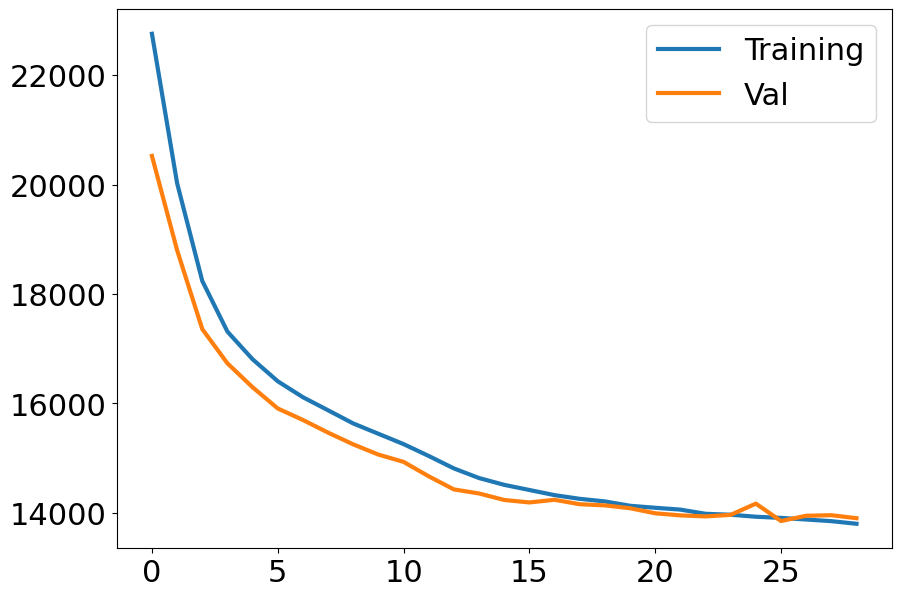

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_loss'], label='Training', lw=3)
plt.plot(logger.metrics['val_loss'], label='Val', lw=3)
plt.legend()
plt.show()

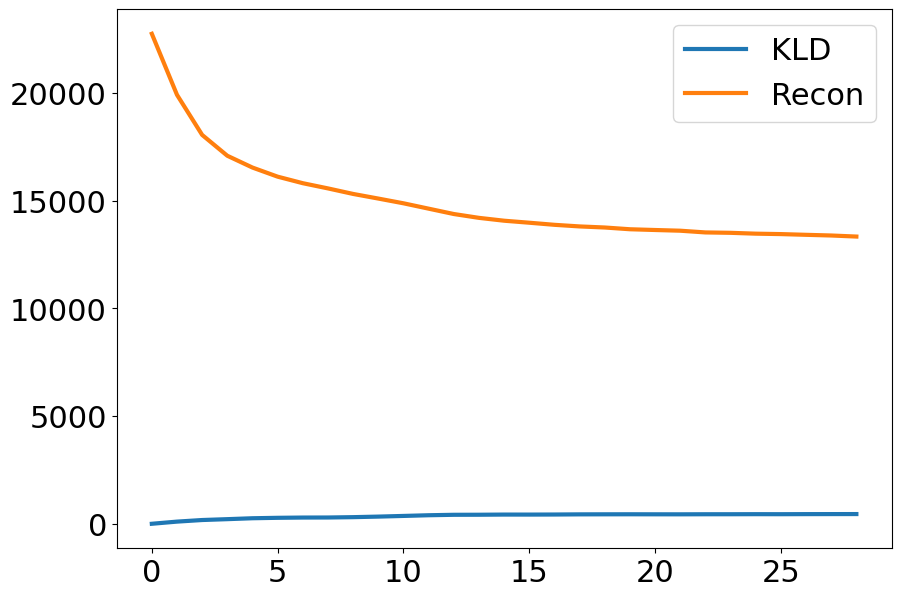

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_kld_loss'], label='KLD', lw=3)
plt.plot(logger.metrics['training_recons_loss'], label='Recon', lw=3)
plt.legend()
plt.show()

### Q1.2 Demonstrate Reconstruction (11 pts)

In the same way as was demonstrated in Tutorial 8, the ability of your model to reconstruct the first two digits from the first batch provided by `dataloader_test`. 

Specifically, pass the first two values of `x` and `y` from `dataloader_test` to `model` and reconstruct these images. Plot them as illustrated below:

![Reconstructed MNIST digits](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.2.webp)

**Note**: The batches are randomised so you won't nescessarily get the same samples shown above.

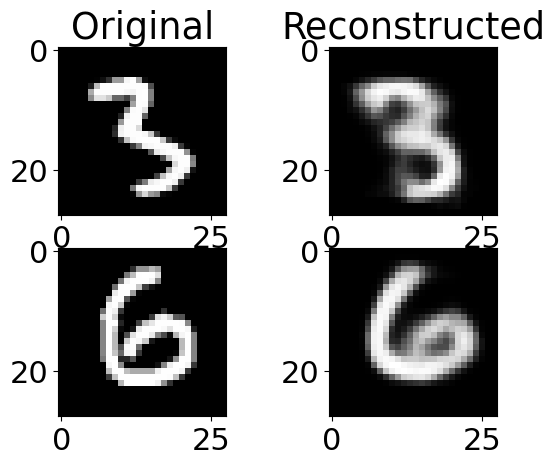

In [13]:
# Q1.2 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)
x = x.view(-1,28*28)
test_out = model(x, y)
mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.3 Demonstrate Conditional Reconstruction (13 pts)

Similar to Q1.2, reconstruct digits, but instead of using the correct $c$ vector, change the class label to a different one.

For example, the value of `y` for the two samples below are 3 and 6, but when reconstructing, the $c$ vector `[0,0,1,0,0,0,0,0,0,0]` was supplied.

![Conditioned Reconstruction](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.3.png)

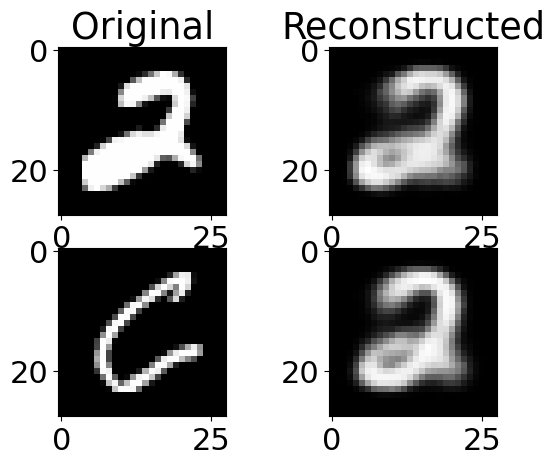

In [14]:
# Q1.3
batch = iter(dataloader_test)
(x, y) = next(batch)
c = torch.Tensor([0,0,1,0,0,0,0,0,0,0]).repeat(x.shape[0], 1)
#c= [0,0,1,0,0,0,0,0,0,0]
x = x.view(-1, 28*28)
test_out = model(x, c.argmax(dim=1))
mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.4 Explore the Latent Space (26 pts)

We now wish to traverse the latent space by individually sweeping each latent variable within a standard deviation. By doing so with a fixed value of $c$, we can better understand what individual latent variables encode for with regard to a specific digit.

Specifically, your task is to:

1. Calculate the mean ($\mu$) of latent vectors `z` from one batch provided by `dataloader_test`
2. Calculate the stdev ($\sigma$) of latent vectors `z` from one batch provided by `dataloader_test`
3. For each combination of $i \in [1\dots n]$ and $j \in [1\dots10]$:
    1. Create a [clone](https://pytorch.org/docs/stable/generated/torch.Tensor.clone.html#torch.Tensor.clone) of the $\mu$ vector named $z^{*(i,j)}$
    2. Calculate $\delta = \frac{(\mu+2\sigma) - (\mu - 2\sigma)}{9}$
    3. Make the $i$th element of $z^{*(i,j)}$ equal to $\mu_i-2\sigma_i + \delta_i \times j$ 
    4. Input into our model's decoder the latent vector $z^{*(i,j)}$ 
  and a $c$ vector that encodes for the number 2 to create an image $\hat{x}^{*(i,j)}$
4. Plot every $\hat{x}^{*(i,j)}$ in a $10\times10$ grid, where each row is a different value of $i$, and each column is a different value of $j$

Recall, $n$ is the number of latent variables.

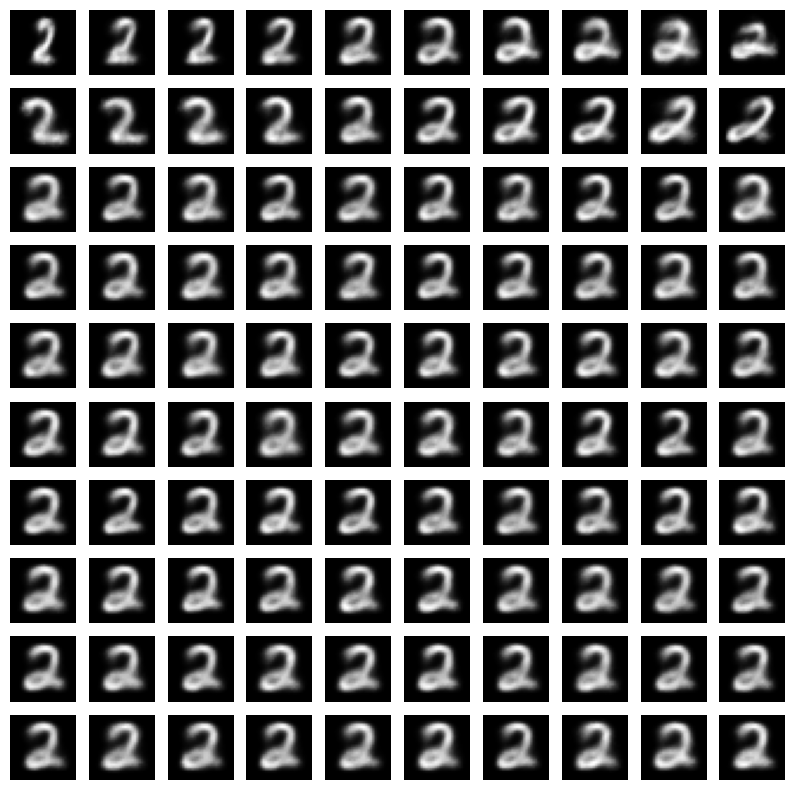

In [15]:
# Q1.4 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)
x = x.view(-1, 28 * 28)

x = x.view(-1, 28 * 28)
test_out = model(x, c.argmax(dim=1))
mu, logvar, z, x_hat = test_out

# Calculating the mean and standard deviation of the latent vectors
z_mean = torch.mean(z, dim=0)
z_std = torch.std(z, dim=0)


n = model.latent_dim

# Create a 10x10 grid to plot the generated images
fig, axs = plt.subplots(n, 10, figsize=(10, n))

# For each combination of i and j
for i in range(n):
    for j in range(10):
        # Create a clone of the mean vector for each combination of i and j
        z_star = z_mean.clone()
        # Calculate delta
        delta = (z_mean + 2 * z_std - (z_mean - 2 * z_std)) / 9
        # Modify the ith element of z_star
        z_star[i] = z_mean[i] - 2 * z_std[i] + j * delta[i]
        # Decode the modified latent vector
        with torch.no_grad():
            x_star = model.decoder(torch.cat((z_star.unsqueeze(0), F.one_hot(torch.tensor([2]), num_classes=10)), 1))
        # Plot the decoded image
        axs[i, j].imshow(x_star.view(28, 28), cmap='gray')
        axs[i, j].axis('off')
plt.show()

## Part 2: Graph Convolution Networks (GCN)

The node update equation for a Graph Convolution layer is given by

$$
\begin{align}
h_u^{(l+1)} = \sigma(b^{(l)} + \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v),
\end{align}
$$

where $u$ is the node, $l$ is the layer, $b$ is the bias, and $W$ is the trainable parameter matrix. Here, $h^{(0)}$ is the node feature.

A 2D Convolution layer without kernel flipping is given by

$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)}),
\end{align}
$$

where $S$ is the feature map, and $K$ is the kernel. Here $S^{(0)}=I$ (*i.e.* original image).

*Hint:* For simplicity, set the biases to 0.

### Q2.1: Describe a graph that is equivalent to an image (6 pts)
Include \textbf{all} the details and technicalities (*e.g.*, which components are equivalent, node connectivity, edge cases, exceptions, indexing). An illustration could help but grading will be solely based on the description. Anything that is part of the illustration that is not described in words will not count as a point. This will be the base graph to be used in your solution for Q2.2 and Q2.3. 

### Q2.2: Assuming that there is no 2D pooling, under which conditions are GraphConv and 2DConv equivalent? (10 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can setup a constraint for some elements to be equal for the CNN and GCN, or equal to a specific values. 

*Hint:* Fix kernel size to a specific size then work on that solution.

### Q2.3: Assuming that there is a 2D pooling after the 2D convolution, under which conditions are GraphConv and 2DConv+2DPool equivalent? (9 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can setup a constraint for some elements to be equal for the CNN and GCN, or equal to a specific values. Do not forget to specify the type of pooling.

*Hint:* The activation function $\sigma$ is a hyperparameter that you can constrain.


### Clarifications 

Q2.2 and Q2.3 pertain to the conditions in which the outputs of the 1-layer GCN is equivalent to the outputs of the 2DConv/2DConv+2DPool.

Let the output of the 2DConv/2DConv+2DPool have the dimensions $(\texttt{out_channels} \times \texttt{out_height} \times \texttt{out_width})$. The GCN should have an output where each of the $\texttt{out_height}*\texttt{out_width}$ nodes has an embedding vector of length $\texttt{out_channels}$, and the nodes/axes can be arranged sucht that the values will be *exactly* equal to that of the 2DConv/2DConv+2DPool.

Look up the documentation for `torch.nn.Conv2d` and `dgl.nn.pytorch.conv.GraphConv` to see which properties need defining in Q2.2 and Q2.3. We will assume the "defaults" for unspecified properties.

*JSYK:* There may be multiple solutions to this problem. You do not need a "generalizable" solution, but we will find loopholes so it is safer to define/constrain all possible properties that could "break" your solution. Our hints only pertain to one specific solution. However, setting all parameters to zero/infinity does not count towards earning points.

### 2.1
For simplicity, set the biases to 0. 
let 
$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)}), (1)
\end{align}
$$
#### Assumption
- As we must preserve graph along multiple updates, we must preserve the image size. 
- Let Image be $Width=W$, $Height=H$, W by H. 
- $I(0, 0)$ is the pixel in the top left corner; $I(W - 1, 0)$ is the pixel in the top right corner; $I(0, H - 1)$ is the pixel in the bottom left corner; $I(W - 1, H - 1)$ is the pixel in the bottom right corner. 
- Let a M by N kernel $ K_{M \times N}^{(l)} $ of size M by N
- Stride is 1, meaning 1 pixel move horizontally and vertically at each step. 
- Padding is added to the bottom and right side of the image. 
- For corner cases when we need a padding (in bottom and right), for each pixel $(i, j)$, if $ i + M > W $, modify the $ \sum_{m} $ in Equation (1) to $\sum_{m=0}^{min(M - 1, W - i - 1)}$. If $ j + N > H $, modify the $ \sum_{n} $ in Equation (1) to $\sum_{n=0}^{min(N - 1, H - j - 1)}$. 
- Single Channel (grayscale) to avoid TA "break" the solution. 
#### Idea
- For each $ (i, j) $ in the feature map, in each 2D element-wise multiplication starting at $(i, j)$ with the  kernel, $ (i, j) $ must be related with other pixels involved in such multiplication.
#### Definition
Let kernel $ K_{M \times N}^{(l)} $,  undirected graph $ G=(V, E) $, where</br>
Verticies $ V = \{(x, y): 0\leq x < W, 0\leq y < H\} $ </br>
Edges $ E=\{ ((x, y), (u, v)) : x \leq u < \min(x + M, W), y \leq v < \min(y + N, H), (x, y) \in V \} $ </br>

### 2.2
For simplicity, set the biases to 0. Grayscale (single-entry channel, $d=0$). 
</br>
As there is no normalization nor scaling of each neighbour when computing an update, $c_{u, v}=1$. We can infer that $S^{(l)}(i, j) \in \mathbb{R}^{d} , K^{(l)}(m, n) \in \mathbb{R}, \forall (i, j) \in \mathbb{Z}_{W} \times \mathbb{Z}_{H}, \forall (m, n) \in \mathbb{Z}_{M} \times \mathbb{Z}_{N}, \forall l \in \mathbb{N}$. Therefore, $S^{(l)}(i+m,j+n) K^{(l)}(m,n) = K^{(l)}(m,n) S^{(l)}(i+m,j+n) $ in Equation (1). 
</br>
By definition of the set of Edges $E$, $N(u)=\{v = (x, y): i \leq x < \min(i + M, W), j \leq y < \min(j + N, H), u = (i, j)\}=\{v = (i + m, j + n): 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j), u = (i, j)\}$
</br>
Then, 
</br>
$\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} S^{(l)}(i+m,j+n) K^{(l)}(m,n)$ becomes
</br>
$\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} K^{(l)}(m,n) S^{(l)}(i+m,j+n)$ (Equation 2). To match with, 
</br>
$\sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v$ , let
</br>
$W^{(l)}=K(m,n)=w \in \mathbb{R}$, $\forall m \in \mathbb{Z}_{m}, n \in \mathbb{Z}_{n}$. In plain English, this means ```a kernel M by N with all its entries being the same```. $b^{(l)}=0 \in \mathbb{R}^{d}$. (Equation 2) becomes, 
</br>
$\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (W^{(l)}S^{(l)}(i+m,j+n) )$ (Equation 3), let
</br>
$N(u)=\{v = (x, y): i \leq x < \min(i + M, W), j \leq y < \min(j + N, H), u = (i, j)\}=\{v = (i + m, j + n): 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j), u = (i, j)\}$, and $h^{(l)}_{v=(x, y)} = S^{(l)}(x, y) \in \mathbb{R}^{d}$, $h^{(l+1)}_{u=(i, j)} = S^{(l+1)}(i, j) \in \mathbb{R}^{d}$, (Equation 3) becomes, 
</br>
$\sum_{v \in N(u)} W^{(l)}h^{(l)}_v$ (Equation 4), 
</br>
let $c_{u,v}=1$ (no normalization), (Equation 4) becomes, $\sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v$. With bias being zero, other parts of the 2 equations are equal. A cleaned-up illustration is 
$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (S^{(l)}(i+m,j+n) K^{(l)}(m,n)) + b^{(l)})\\
 &=\sigma(\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (K^{(l)}(m,n) S^{(l)}(i+m,j+n)) + b^{(l)}), W^{(l)}=K(m,n)=w \in \mathbb{R}, \forall m \in \mathbb{Z}_{m}, n \in \mathbb{Z}_{n}\\
 &= \sigma(\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (W^{(l)}S^{(l)}(i+m,j+n) ) + b^{(l)}), N(u)=\{v = (x, y): i \leq x < \min(i + M, W), j \leq y < \min(j + N, H), u = (i, j)\}=\{v = (i + m, j + n): 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j), u = (i, j)\}, h^{(l)}_{v=(x, y)} = S^{(l)}(x, y) \in \mathbb{R}^{d}\\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} W^{(l)}h^{(l)}_v + b^{(l)}), c_{u,v}=1 \\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} \frac{1}{c_{u,v}}W^{(l)}h^{(l)}_v + b^{(l)}), h^{(l+1)}_{u=(i, j)} = S^{(l+1)}(i, j) \in \mathbb{R}^{d}\\
 &= h_{u}^{(l+1)}, u=(i, j)\\
\end{align}
$$

### 2.3
For simplicity, set the biases to 0.Grayscale (single-entry channel, $d=0$). 
</br>
Given a pooling function Pool2D. A 2D pooling after 2D Convolution is: 
$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma(Pool2D(S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(Pool2D(A) + b^{(l)}), where:  A_{m, n}=S^{(l)}(i+m,j+n) K^{(l)}(m,n), for: 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j)
\end{align}
$$
Therefore, to match with definition of GCN, ``output of function Pool2D must be a linear combination of entries of A (outputs of multiplication)``, which are, again, neighbours of $u$ in the def. of GCN. 
</br>
If we set $Pool2D=AveragePool$, $c_{u,v}$ can be computed by $(i, j)$, $c_{u,v}=\min(M, W - i) \cdot \min(N, H - j)$ being the number of terms after multiplication. 
$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma(AveragePool(S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(AveragePool(A) + b^{(l)}), where:  A_{m, n}=S^{(l)}(i+m,j+n) K^{(l)}(m,n), for: 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j) \\
 &= \sigma(\frac{1}{\min(M, W - i) \cdot \min(N, H - j)}\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (K^{(l)}(m,n)S^{(l)}(i+m,j+n) ) + b^{(l)}), by (2.1)\\
 &= \sigma(\frac{1}{\min(M, W - i) \cdot \min(N, H - j)}\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (W^{(l)}S^{(l)}(i+m,j+n) ) + b^{(l)})\\
 &= \sigma(\frac{1}{\min(M, W - i) \cdot \min(N, H - j)}\sum_{v \in N(u), u=(i, j)} W^{(l)}h^{(l)}_v + b^{(l)})\\
 &= \sigma(\frac{1}{c_{u,v}}\sum_{v \in N(u), u=(i, j)} W^{(l)}h^{(l)}_v + b^{(l)}), c_{u,v}=\min(M, W - i) \cdot \min(N, H - j)\\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} \frac{1}{c_{u,v}}W^{(l)}h^{(l)}_v + b^{(l)}), c_{u,v}=\min(M, W - i) \cdot \min(N, H - j)\\
 &= h_{u}^{(l+1)}, u=(i, j)\\
\end{align}
$$
Another possible Pool2D is WeightedAverage, according to documentation of ```dgl.nn.pytorch.conv.GraphConv```, there is a parameter $e_{ji}$ for "the scalar weight on the edge from node $j$ to node $i$". We can use such $e_{ji}$ to implement weighted average. 
$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma(WeightedAverage(S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(WeightedAverage(A) + b^{(l)}), where:  A_{m, n}=S^{(l)}(i+m,j+n) K^{(l)}(m,n), for: 0 \leq m < \min(M, W - i), 0 \leq n < \min(N, H - j) \\
 &= \sigma(\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (w_{m, n}K^{(l)}(m,n)S^{(l)}(i+m,j+n) ) + b^{(l)}), by (2.1)\\
 &= \sigma(\sum_{m=0}^{min(M - 1, W - i - 1)} \sum_{n=0}^{min(N - 1, H - j - 1)} (w_{m, n}W^{(l)}S^{(l)}(i+m,j+n) ) + b^{(l)})\\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} w_{m, n}W^{(l)}h^{(l)}_v + b^{(l)})\\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} \frac{w_{m,n}}{c_{j,i}}W^{(l)}h^{(l)}_v + b^{(l)}), c_{j,i}=1\\
 &= \sigma(\sum_{v \in N(u), u=(i, j)} \frac{e_{j,i}}{c_{j,i}}W^{(l)}h^{(l)}_v + b^{(l)}), c_{j,i}=1, e_{u, v}=w_{m,n}\\
 &= h_{u}^{(l+1)}, u=(i, j)\\
\end{align}
$$
Note: finding correspondence between $w_{m,n}$ and $e_{u, v}$ is possible by recording each "unidirectional" weight between 2 pixels during (parallel) convolution/affine step. 